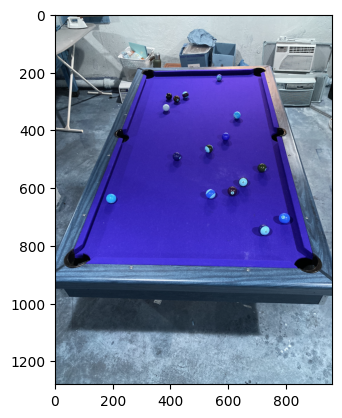

In [1]:
#import cv2, numpy and matplotlib libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
  
x1='images/all_balls/1280x1280/1.png'
grayscale = cv2.imread(x1, 0)
image1 = cv2.imread(x1,1)

plt.imshow(image1)
plt.show() 
  

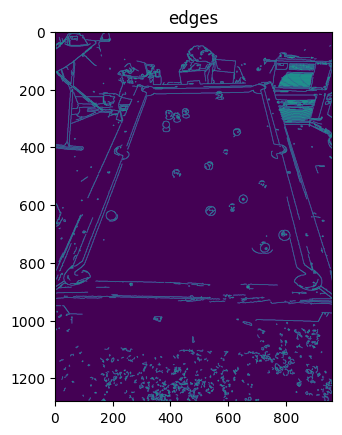

In [2]:
img_blur = cv2.GaussianBlur(grayscale, (3,3), 0) 
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
plt.title('edges')
plt.imshow(edges)
plt.show()

Limit the image to only the pool table. Credit to Ben
Perhaps could optimize to use a histogram to progamatically get the color of the felt

In [3]:
# order is blue, green, red
lower_blue = np.array([0,0,150])
upper_blue = np.array([150,100,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(image1, lower_blue, upper_blue)
erosion = mask
kernel = np.ones((7,7),np.uint8)
dilation = cv2.dilate(erosion, kernel, iterations = 4)

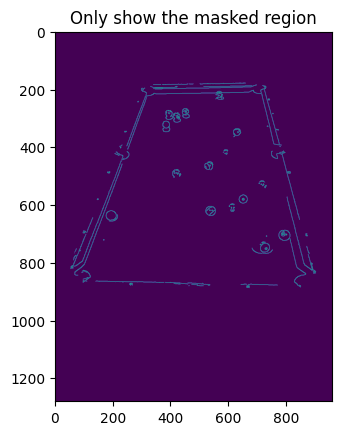

In [4]:
res = cv2.bitwise_and(edges, dilation)
plt.title('Only show the masked region')
plt.imshow(res)
plt.show()

3.891881427586605 222.9660361107799
(-1495, 249) (1503, 196)
624.9539930850789 -167.4559838495332
(236, -1616) (1013, 1281)
348.22549772009984 133.6712487320618
(-189, 1534) (885, -1266)
352.3847340971163 128.2575501688094
(-160, 1537) (865, -1281)
620.0189754109737 -154.5880659375956
(257, -1610) (982, 1300)
-15.043926822047878 861.8687140543929
(-1514, 835) (1484, 888)
3.3334051689194686 190.97090985273076
(-1496, 217) (1503, 164)


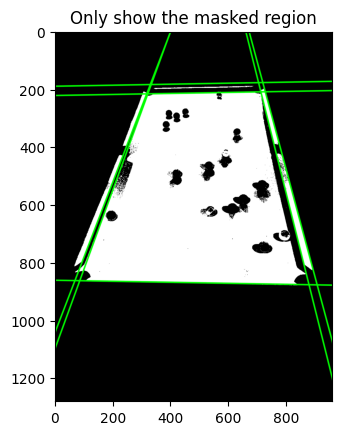

In [5]:

import math

msk_lines = np.zeros((1280, 960,3), dtype=np.uint8)
img_lines = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(res,1,np.pi/180,190,None,0,0)
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            print(x0, y0)
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            print (pt1, pt2)
            cv2.line(msk_lines, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)
            cv2.line(img_lines, pt1, pt2, (0,255,0), 3, cv2.LINE_AA)

plt.title('Only show the masked region')
plt.imshow(img_lines)
plt.show()

https://www.geeksforgeeks.org/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/?ref=rp
Shi-Thomas Corner Detection

(325, 213)
(90, 860)
(706, 207)
(872, 874)


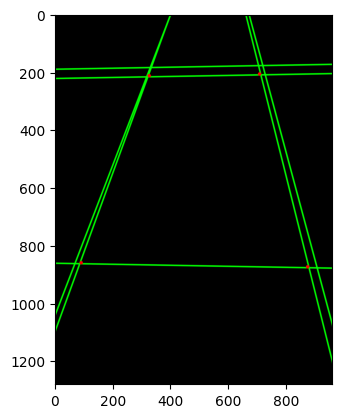

In [26]:
gry_msk_lines = cv2.cvtColor(msk_lines, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gry_msk_lines, 100, 0.01, 10)
msk_lines_out = msk_lines.copy()

corners = np.intp(corners)
h,w, = msk_lines_out.shape[:2]
c1 = [0, 0]
c2 = [0, w]
c3 = [h, 0]
c4 = [h, w]

center = [h/2, w/2]

table_c_dist1 = math.dist(c1, center)
table_c_dist2 = math.dist(c2, center)
table_c_dist3 = math.dist(c3, center)
table_c_dist4 = math.dist(c4, center)

table_corner1 = c1
table_corner2 = c2
table_corner3 = c3
table_corner4 = c4

for i in corners:
    x, y = i.ravel()
    euc_1 = math.dist(c1,[x,y])
    euc_2 = math.dist(c2,[x,y])
    euc_3 = math.dist(c3,[x,y])
    euc_4 = math.dist(c4,[x,y])

    dist = [euc_1, euc_2, euc_3, euc_4]
    min_euc = min(dist)

    if euc_1 == min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist1:
            table_c_dist1 = euc_cen
            table_corner1 = (x,y)
    elif euc_2 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist2:
            table_c_dist2 = euc_cen
            table_corner2 = (x,y)    
    elif euc_3 ==  min_euc:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist3:
            table_c_dist3 = euc_cen
            table_corner3 = (x,y) 
    else:
        euc_cen = math.dist(center, [x,y])
        if euc_cen < table_c_dist4:
            table_c_dist4 = euc_cen
            table_corner4 = (x,y) 
    # find which quadrant
    # draw red color circles on all corners
print(table_corner1)
print(table_corner2)
print(table_corner3)
print(table_corner4)

cv2.circle(msk_lines_out, table_corner1, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_corner2, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_corner3, 6, (255, 0, 0), -1)
cv2.circle(msk_lines_out, table_corner4, 6, (255, 0, 0), -1)

# resulting image
plt.imshow(msk_lines_out)
